# Testing Algorithms

This jupyter notebook is intended to test the behaviour of an algorithm at small scale, emulating large parts of the simulator to be able to do algorithm testing

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..', 'simulator/src')))
sys.path.append(os.path.abspath(os.path.join('../..', "algorithm/src")))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import math
import json

1. Open a topology

In [3]:
with open("../../external_resources/sim_topologies/12N34E_20cl_2Gb_dir_200c.json") as json_file:
    network = json.load(json_file)

2. Create a simulation environment, define the algorithm and initialize the algorithm

In [5]:
from simulator.simulation.simulation import Simulation
from algorithm.algorithms.mesh_agg_bal import MeshAggBal
from algorithm.algorithms.hfel import HFEL
from algorithm.algorithms.hfel_mesh import HFELMESH

sim = Simulation("./sim_config.json")
sim.build_environment("../../external_resources/sim_topologies/12N34E_20cl_2Gb_dir_200c.json")

mcf = HFELMESH()
mcf.setup_algorithm(sim.env.config["algorithm"])
mcf.load_network(network)


3. Create a request graph to be placed 

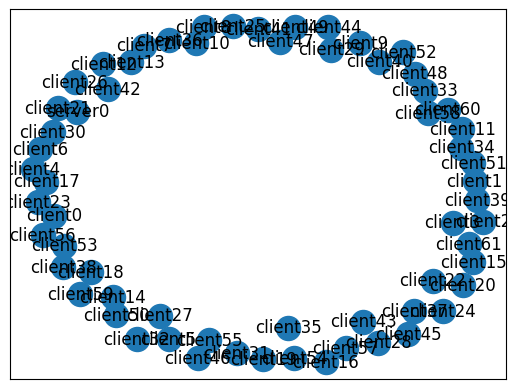

In [6]:
mcf.load_network(network)
sfc = sim.fl_service.new_sfc()
nx.draw_networkx(sfc.graph)

4. Initialize a network status in the algorithm so that the algorithm can calculate a request placement

In [7]:
mcf.network_status = nx.DiGraph()
for node_id, node in mcf.network.nodes.items():
    if node["type"] != "iot":
        mcf.network_status.add_node(node_id, computational_resource={"utilization": 0})
for link_id, link in mcf.network.edges.items():
    if link["type"] != "iot":
        mcf.network_status.add_edge(*link_id, tunnel={"utilization": 0})

for node_id, node in mcf.network_status.nodes.items():
    mcf.network_status.nodes[node_id]["computational_resource"]["current_occupation_rel"] = mcf.rng.uniform(0,1)
    mcf.network_status.nodes[node_id]["computational_resource"]["current_available_capacity"] = mcf.rng.randint(100,200)
    mcf.network_status.nodes[node_id]["computational_resource"]["failed_tasks"] = mcf.rng.randint(0,4)
    mcf.network_status.nodes[node_id]["computational_resource"]["total_tasks"] = mcf.rng.randint(10,20)
for link_id, link in mcf.network_status.edges.items():
    mcf.network_status.edges[link_id]["tunnel"]["current_occupation_rel"] = mcf.rng.uniform(0,1)
    mcf.network_status.edges[link_id]["tunnel"]["current_available_capacity"] = mcf.rng.randint(100,200)
    mcf.network_status.edges[link_id]["tunnel"]["failed_tasks"] = mcf.rng.randint(0,4)
    mcf.network_status.edges[link_id]["tunnel"]["total_tasks"] = mcf.rng.randint(10,20)
    

5. execute the algorithm

In [8]:
placed_sfc = mcf.place_sfc(sfc.graph)

In [12]:
# Check auxiliary graph of algorithm if applicable

# for node_id, node in mcf.aux_graph.nodes.items():
#     if len(list(mcf.aux_graph.successors(node_id))) > 0:
#         for suc in mcf.aux_graph.successors(node_id):
#             print(f"{(node_id, suc)}: {mcf.aux_graph.edges[(node_id, suc)]['weight']}")
        # print(f"{node_id}: {list(mcf.aux_graph.successors(node_id))}")
    # else:
    #     print(f"{node_id}: {list(mcf.aux_graph.successors(node_id))}")

6. Remove clients (if necessary) and plot the resulting request structure

True

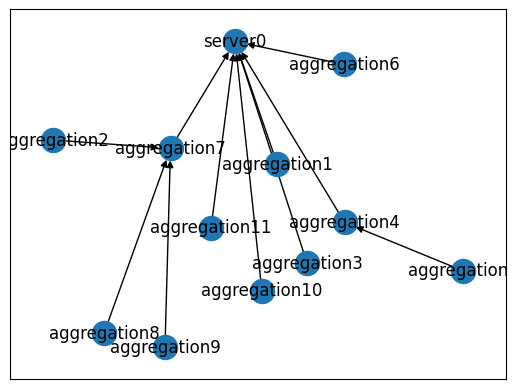

In [9]:
for client in mcf.clients:
    placed_sfc.remove_node(client)
pos = nx.spring_layout(placed_sfc, seed=12)
nx.draw_networkx(placed_sfc, pos=pos)
nx.is_directed_acyclic_graph(placed_sfc)

## Extract clients and targets of every aggregator

In [11]:
for aggregator in mcf.aggregators.values():
    if aggregator in placed_sfc.nodes:
        clients = [pred for pred in placed_sfc.predecessors(aggregator)]
        servers = [pred for pred in placed_sfc.successors(aggregator)]
        print(f"{aggregator}:\t{clients}\t{servers}")

aggregation1:	[]	['server0']
aggregation2:	[]	['aggregation7']
aggregation3:	[]	['server0']
aggregation4:	['aggregation5']	['server0']
aggregation5:	[]	['aggregation4']
aggregation6:	[]	['server0']
aggregation7:	['aggregation2', 'aggregation8', 'aggregation9']	['server0']
aggregation8:	[]	['aggregation7']
aggregation9:	[]	['aggregation7']
aggregation10:	[]	['server0']
aggregation11:	[]	['server0']


## Print information on every aggregator 

In [12]:
for node_id, node in placed_sfc.nodes.items():
    print(node_id)
    print(f'network_id: {node["parameters"]["network_id"]}')
    print(f'requested_capacity: {node["parameters"]["requested_capacity"]}')
    if len(list(placed_sfc.successors(node_id))) > 0:
        successor = list(placed_sfc.successors(node_id))[0]
        print(f'successors: {successor}')
        link = placed_sfc.edges[(node_id, successor)]
        print(f'path: {link["parameters"]["network_path"]}')
        print(f'cap: {link["parameters"]["requested_capacity"]}')
    print("\n")

server0
network_id: cloud_1_1
requested_capacity: 2


aggregation1
network_id: edge_1_1
requested_capacity: 6
successors: server0
path: ['edge_1_1', 'cloud_1_1']
cap: 34


aggregation2
network_id: edge_2_1
requested_capacity: 3
successors: aggregation7
path: ['edge_2_1', 'edge_7_1']
cap: 34


aggregation3
network_id: edge_3_1
requested_capacity: 6
successors: server0
path: ['edge_3_1', 'cloud_1_1']
cap: 21


aggregation4
network_id: edge_4_1
requested_capacity: 2
successors: server0
path: ['edge_4_1', 'cloud_1_1']
cap: 37


aggregation5
network_id: edge_5_1
requested_capacity: 4
successors: aggregation4
path: ['edge_5_1', 'edge_4_1']
cap: 36


aggregation6
network_id: edge_6_1
requested_capacity: 2
successors: server0
path: ['edge_6_1', 'edge_2_1', 'cloud_1_1']
cap: 27


aggregation7
network_id: edge_7_1
requested_capacity: 7
successors: server0
path: ['edge_7_1', 'cloud_1_1']
cap: 27


aggregation8
network_id: edge_8_1
requested_capacity: 4
successors: aggregation7
path: ['edge_8_1', 